In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import cv2

In [2]:
def ncc(matA, matB):
    sum = 0
    aNorm = np.divide(matA, np.linalg.norm(matA, axis=0).T, where=matA!=0)
    bNorm = np.divide(matB, np.linalg.norm(matB, axis=0).T, where=matB!=0)
    # print(aNorm.shape)
    sum += np.sum(np.einsum('ij, ij -> i', aNorm, bNorm))
    # for y in range(0, matA.shape[0]):
    #     matAVec = aNorm[y, :]
    #     matBVec = aNorm[y, :]
    #     sum += np.dot(np.divide(matAVec, aNorm), np.divide(matBVec, bNorm, where= bNorm!=0))
    aNorm = np.divide(matA, np.linalg.norm(matA, axis=1)[:, None], where=matA!=0)
    bNorm = np.divide(matB, np.linalg.norm(matB, axis=1)[:, None], where=matB!=0)
    # print(aNorm.shape)
    sum += np.sum(np.einsum('ij, ij -> j', aNorm, bNorm))
    # for x in range(0, matA.shape[1]):
    #     matAVec = matA[:, x]
    #     matBVec = matB[:, x]
    #     aNorm = np.linalg.norm(matAVec)
    #     bNorm = np.linalg.norm(matBVec)
    #     sum += np.dot(np.divide(matAVec, aNorm), np.divide(matBVec, bNorm, where= bNorm!=0))
    return sum
    # return np.corrCoef(matA, matB)

def shift_frame(x_shift, y_shift, matA, zeroPad = False):
    if x_shift < 0:
        if y_shift < 0:
            return np.pad(matA[:y_shift, :x_shift], ((0, -y_shift), (0, -x_shift)), mode="constant") if zeroPad else matA[:y_shift, :x_shift]
        else:
            return np.pad(matA[y_shift: ,:x_shift], ((y_shift, 0), (0, -x_shift)), mode="constant") if zeroPad else matA[y_shift: ,:x_shift]
    else:
        if y_shift < 0:
            return np.pad(matA[:y_shift ,x_shift:], ((0, -y_shift), (x_shift, 0)), mode="constant") if zeroPad else matA[:y_shift ,x_shift:]
        else:
            return np.pad(matA[y_shift: ,x_shift:], ((y_shift, 0), (x_shift, 0)), mode="constant") if zeroPad else matA[y_shift: ,x_shift:]

In [3]:
def find_shift(baseFrame, layerFrame, pyramidLayer):
    if (pyramidLayer > 1):
        shiftRange = find_shift(sk.transform.rescale(baseFrame, 0.5, anti_aliasing = True), sk.transform.rescale(layerFrame, 0.5, anti_aliasing = True), pyramidLayer - 1)
    shift = []
    # bestFrame = []
    maxCorr = 0

    print("Pyramid layer/img shape", pyramidLayer, baseFrame.shape)
    if (pyramidLayer > 1):
        print("shiftRange: ", shiftRange[-2])
        highXRange = shiftRange[-1][0] * 2 + max(np.floor(baseFrame.shape[1] / 2 * 0.005).astype(int) + 1, 5)
        lowXRange = shiftRange[-1][0] * 2 - max(np.floor(baseFrame.shape[1] / 2 * 0.005).astype(int) + 1, 5)
        highYRange = shiftRange[-1][1] * 2 + max(np.floor(baseFrame.shape[0] / 2 * 0.005).astype(int) + 1, 5)
        lowYRange = shiftRange[-1][1] * 2 - max(np.floor(baseFrame.shape[0] / 2 * 0.005).astype(int) + 1, 5)
    else:
        highXRange = max(np.floor(baseFrame.shape[1] * 0.04).astype(int), 25)
        lowXRange = -highXRange
        highYRange = max(np.floor(baseFrame.shape[0] * 0.04).astype(int), 25)
        lowYRange = -highYRange
    print(f"roll range x/y: {lowXRange} - {highXRange-1}, {lowYRange} - {highYRange-1}")
    
    for y in range(lowYRange, highYRange):
        yShifted = np.roll(layerFrame, y, axis=0)
        for x in range(lowXRange, highXRange):
            xShifted = np.roll(yShifted, x, axis=1)
            layerFrameCropped = shift_frame(x, y, xShifted)
            baseFrameCropped = shift_frame(x, y, baseFrame)
            corrScore = ncc(baseFrameCropped, layerFrameCropped)
            # print(y,x)
            # print(corrScore)
            if corrScore > maxCorr:
                print(corrScore, y, x)
                maxCorr = corrScore
                # print(corrScore)
                # bestFrame = [baseFrameCropped, layerFrameCropped]
                shift.append([x,y])
             
    # matchedFrame = np.stack((bestFrame[0], np.empty_like(bestFrame[0]), np.empty_like(bestFrame[0])), axis=2)   
    # matchedFrame = cv2.normalize(np.sum(bestFrame, axis=0), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # fig, axs = plt.subplots(1, 2, figsize=(20, 30))
    # axs[0].imshow(bestFrame[0], cmap='gray', vmin=0, vmax=1)
    # axs[1].imshow(bestFrame[1], cmap='gray', vmin=0, vmax=1)
    # plt.show()
    return shift

In [4]:
# name of the input file
imname = './data/emir.tif'

# read in the image
im = skio.imread(imname, cv2.IMREAD_GRAYSCALE)
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

v_border = int(r.shape[0]*0.1)
h_border = int(r.shape[1]*0.1)
r_cropped = sk.util.img_as_float(r[v_border:-v_border, h_border:-h_border])
b_cropped = sk.util.img_as_float(b[v_border:-v_border, h_border:-h_border])
g_cropped = sk.util.img_as_float(g[v_border:-v_border, h_border:-h_border])
rgb = np.array([r_cropped, g_cropped, b_cropped])


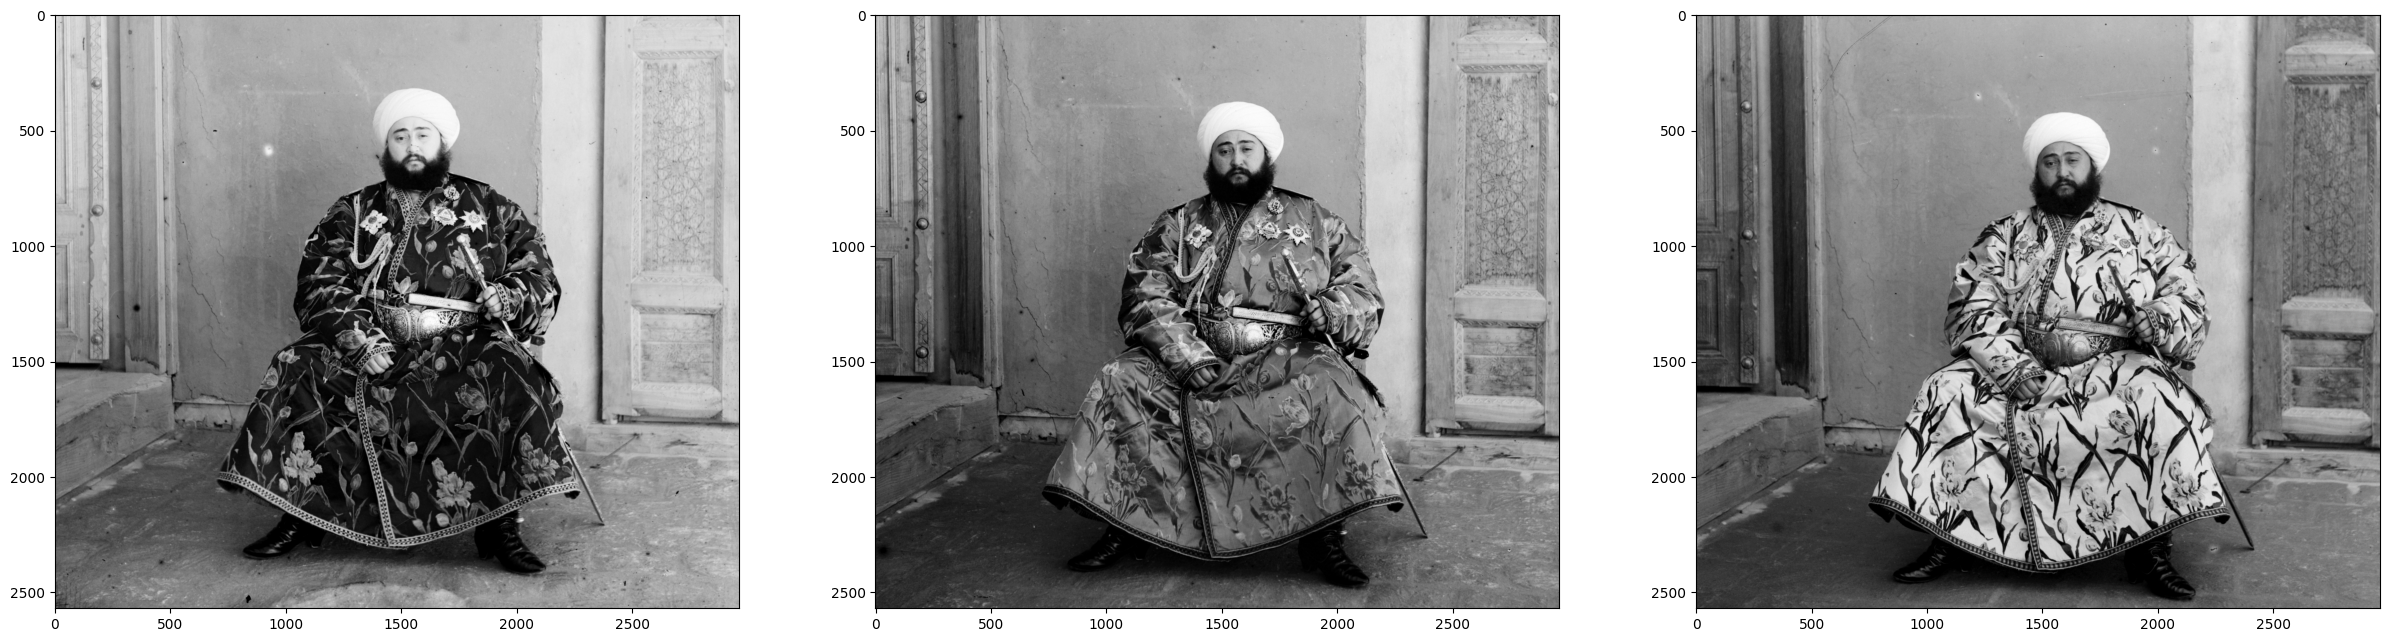

In [5]:
for i in range(0, 3):
    img_adj = rgb[i]
    blackpoint = np.percentile(img_adj, 1)
    # print(blackpoint)
    img_adj = np.clip(img_adj - blackpoint, 0, 1).astype(np.float64)
    
    img_adj = 1 - img_adj
    img_adj = 1.2 * img_adj
    img_adj = 1 - img_adj

    rgb[i] = cv2.normalize(img_adj, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
r_cropped = rgb[0]
g_cropped = rgb[1]
b_cropped = rgb[2]

fig, axs = plt.subplots(1, 3, figsize=(30, 40))
axs[0].imshow(r_cropped, cmap='gray', vmin=0, vmax=1)
axs[1].imshow(g_cropped, cmap='gray', vmin=0, vmax=1)
axs[2].imshow(b_cropped, cmap='gray', vmin=0, vmax=1)
plt.show()

In [6]:
low = 200
high = 400

redEdge = rgb[0]*255
redEdge = cv2.Canny(image=redEdge.astype(np.uint8), threshold1=low, threshold2=high)

greenEdge = rgb[1]*255
greenEdge = cv2.Canny(image=greenEdge.astype(np.uint8), threshold1=low, threshold2=high)

blueEdge = rgb[2]*255
blueEdge = cv2.Canny(image=blueEdge.astype(np.uint8), threshold1=low, threshold2=high)

# edge = cv2.GaussianBlur(edge, (kernel, kernel), 0)

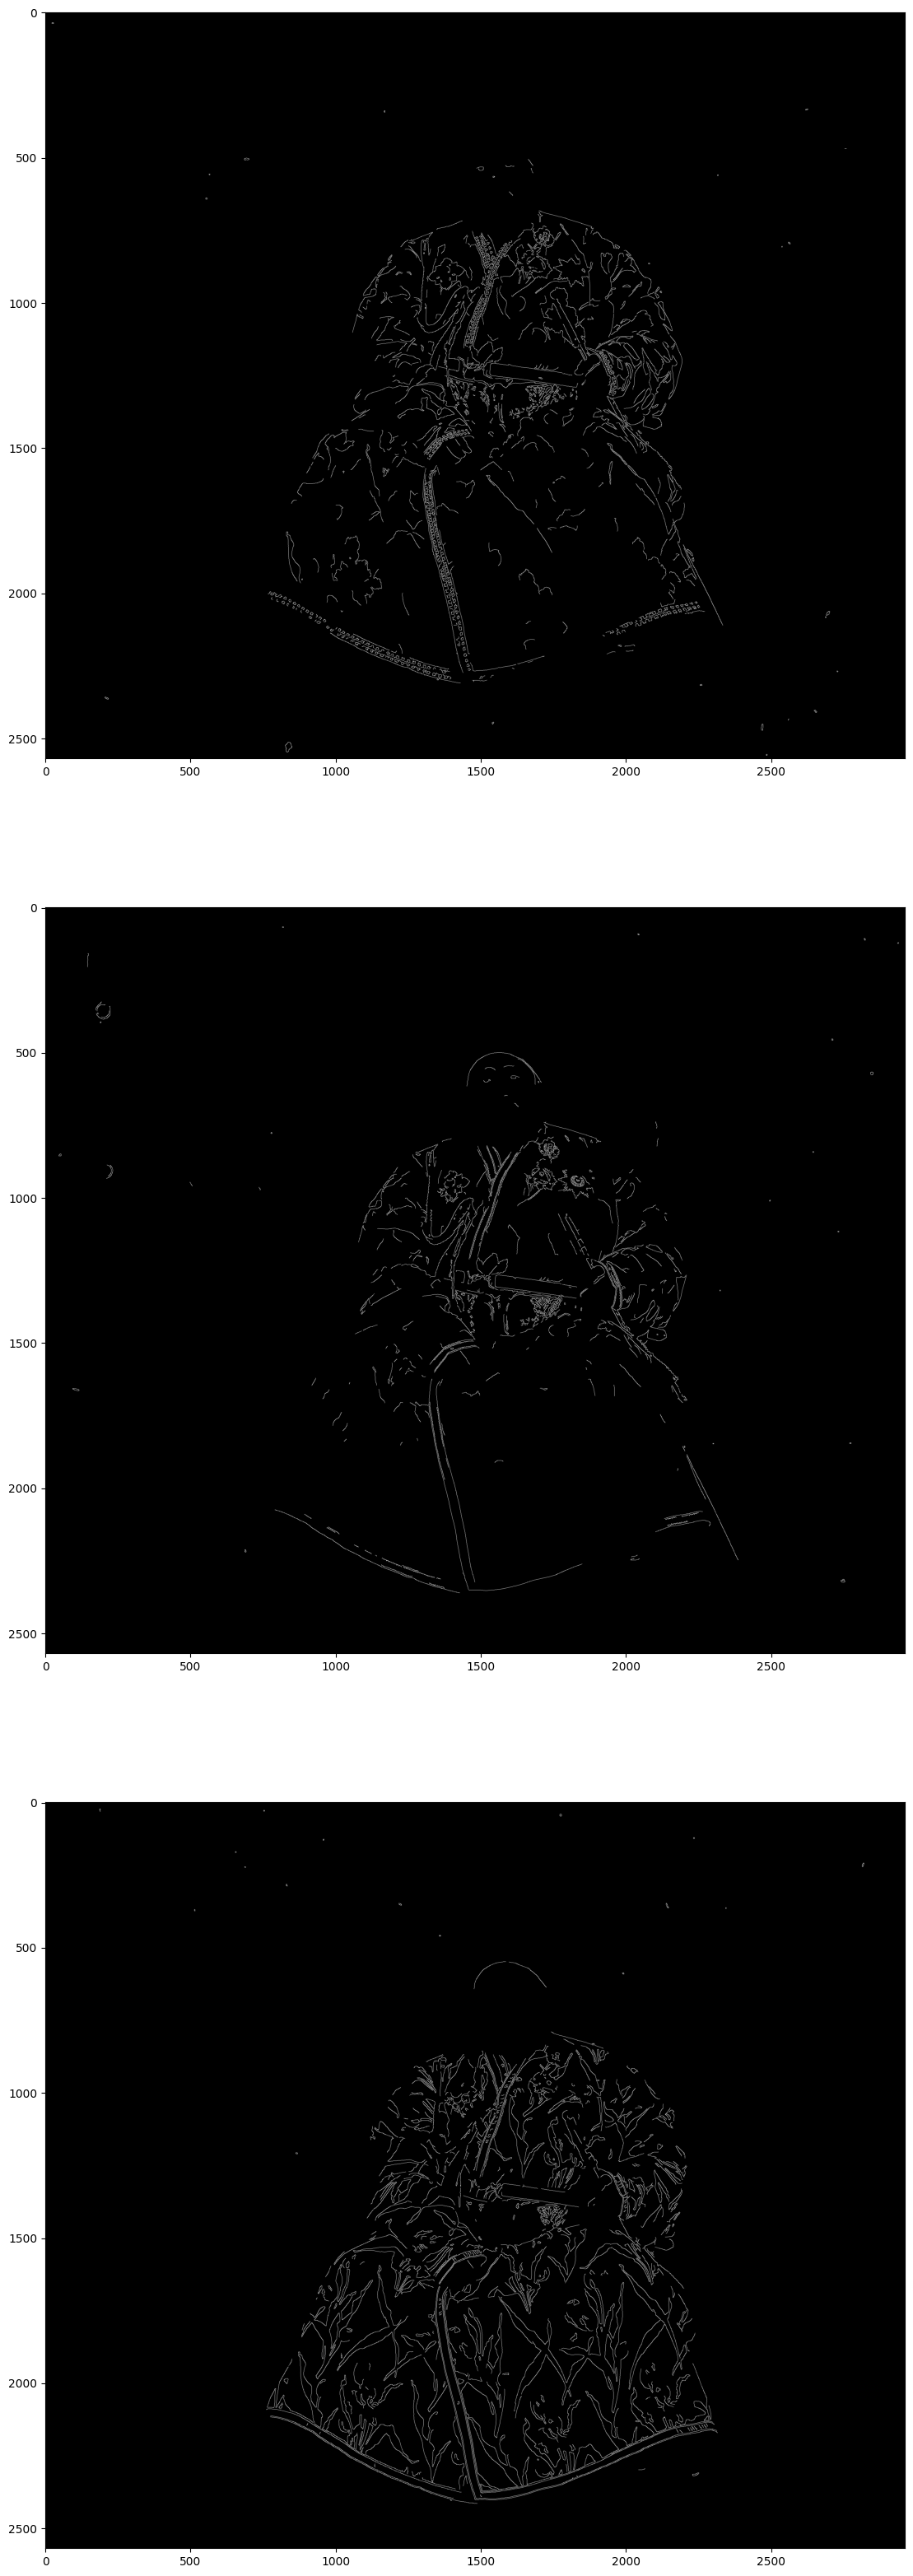

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(30, 40))


axs[0].imshow(redEdge, cmap='gray')
axs[1].imshow(greenEdge, cmap='gray')
axs[2].imshow(blueEdge, cmap='gray')

In [8]:
shift = []
shift.append(find_shift(blueEdge, greenEdge, 4))
print()
shift.append(find_shift(blueEdge, redEdge, 4))
    
print(shift[0][-1], shift[1][-1])

Pyramid layer/img shape 1 (321, 370)
roll range x/y: -25 - 24, -25 - 24
52.110761118597964 -25 -25
53.51150878823365 -25 -20
54.55635689696338 -25 -18
54.77031444992249 -25 -14
57.19458849787604 -25 -13
59.42409486246129 -25 -5
62.33760090082567 -25 -4
63.686099913992535 -24 -4
64.16796647795222 -21 -2
64.33074909364393 -20 -3
64.40348628103595 -20 1
67.22812789228851 -19 -3
67.25718090680675 -18 11
68.87628673464843 -17 -2
69.02311469581355 -17 10
70.05527583657093 -17 11
70.52008930822936 -16 -2
73.62562278379221 -15 -2
75.92172510858023 -14 -2
76.53212542637719 -14 -1
76.94834702754935 -13 -1
77.74416756940116 -7 0
78.09265782099078 -6 0
79.10970881106238 -5 -9
82.70865070426333 -5 -8
83.14774295567656 -4 -7
84.61883720063292 -1 1
86.55177853650571 0 0
95.63508052708056 0 1
100.98640584589208 1 1
105.82004227298074 2 2
106.2436152266798 4 -1
108.73150098395058 5 0
109.94142251843913 5 1
128.12743779573654 5 2
132.14381870297302 5 3
147.6120494788995 6 2
186.3017629906512 6 3
Pyramid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.737156628785687e-18..1.0].


(2569, 2962) (2569, 2962) (2569, 2962)


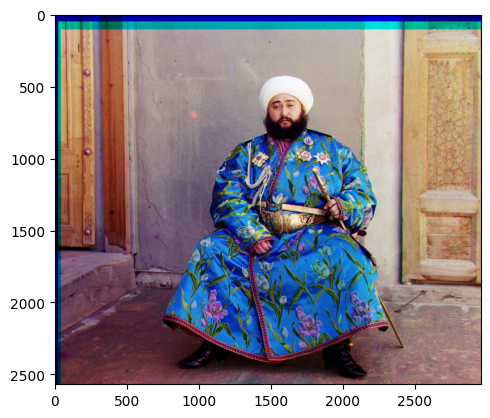

In [9]:
finalShift = np.array([shift[0][-1], shift[1][-1]])

b = b_cropped
g = shift_frame(finalShift[0, 0], finalShift[0, 1], np.roll(g_cropped, (finalShift[0, 0], finalShift[0, 1]), axis=(1, 0)), zeroPad=True)
r = shift_frame(finalShift[1, 0], finalShift[1, 1], np.roll(r_cropped, (finalShift[1, 0], finalShift[1, 1]), axis=(1, 0)), zeroPad=True)
print(r.shape, g.shape, b.shape)
# fig, axs = plt.subplots(1, 3, figsize=(20, 30))
# axs[0].imshow(b, cmap='gray', vmin=0, vmax=1)
# axs[1].imshow(g, cmap='gray', vmin=0, vmax=1)
# axs[2].imshow(r, cmap='gray', vmin=0, vmax=1)
# plt.show()

bgr = np.array([r,g,b])
colorized= np.stack((r,g,b), axis=2)
# converter = ImageEnhance.Color(image=colorized)
# enhanced = converter.enhance(1.5)
plt.imshow(colorized)

In [10]:
maxShifts = np.clip(np.max(finalShift, axis=0), a_min = 0, a_max = None)
minShifts = np.clip(np.min(finalShift, axis=0), a_min = None, a_max = 0)

if minShifts[0] < 0:
    if minShifts[1] < 0:
        bgr = bgr[:, maxShifts[1]:minShifts[1], maxShifts[0]:minShifts[0]]
    else:
        bgr = bgr[:, maxShifts[1]:, maxShifts[0]:minShifts[0]]
else:
    if minShifts[1] < 0:
        bgr = bgr[:, maxShifts[1]:minShifts[1], maxShifts[0]:]
    else:
        bgr = bgr[:, maxShifts[1]:, maxShifts[0]:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.737156628785687e-18..1.0].


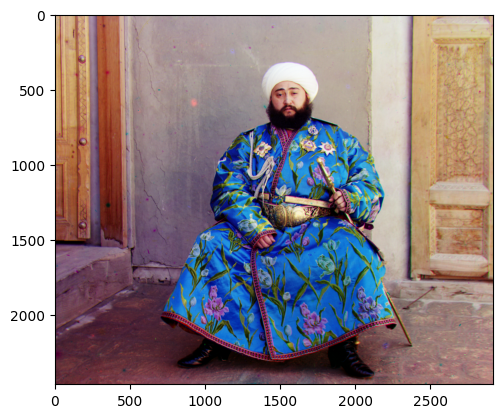

In [12]:
# colorized = (1 - np.stack((bgr[0],bgr[1],bgr[2]), axis=2))
colorized = (np.stack((bgr[0],bgr[1],bgr[2]), axis=2))
colorized = cv2.normalize(colorized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
plt.axis('off')
plt.imshow(colorized)
plt.savefig(f'./Writeup/ImgData/emir_colourized.jpg', bbox_inches='tight', pad_inches=0)